In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
bank = pd.read_csv('https://raw.githubusercontent.com/christianolivamoya/MIAX11-ML/main/data/bank.csv', sep=';')
bank.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3834,36,self-employed,married,secondary,no,189,yes,no,cellular,19,nov,136,1,120,1,failure,no
1807,31,management,married,tertiary,no,6290,no,no,cellular,20,nov,303,2,-1,0,unknown,no
404,50,blue-collar,married,secondary,no,887,no,no,unknown,16,jun,287,1,-1,0,unknown,no
894,37,technician,married,tertiary,no,0,yes,no,cellular,17,nov,77,1,-1,0,unknown,no
3769,51,housemaid,married,primary,no,492,yes,no,unknown,20,may,142,3,-1,0,unknown,no


In [3]:
bank.drop(columns=['day', 'month'], inplace=True)
educ_mapping = {'unknown':0,
                'primary':1,
                'secondary':2,
                'tertiary':3}
noyes_mapping = {'no':False, 'yes':True}
bank['education'].replace(educ_mapping, inplace=True)
bank['y'].replace(noyes_mapping, inplace=True) # Cambio el target a True (1) o False (0)
bank['default'].replace(noyes_mapping, inplace=True)
bank['housing'].replace(noyes_mapping, inplace=True)
bank['loan'].replace(noyes_mapping, inplace=True)

features = bank.drop(columns='y')
target = bank['y']

features = pd.get_dummies(features)
features.sample(5)

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3754,36,3,False,2944,False,False,882,8,-1,0,...,False,False,True,True,False,False,False,False,False,True
3108,38,1,False,1679,True,False,21,18,-1,0,...,False,True,False,False,False,True,False,False,False,True
725,31,3,False,1010,True,False,385,3,364,9,...,False,True,False,True,False,False,False,True,False,False
4166,42,0,False,344,True,False,26,7,-1,0,...,False,False,True,False,False,True,False,False,False,True
3642,52,3,False,83,False,False,1223,6,-1,0,...,False,False,True,True,False,False,False,False,False,True


In [4]:
dataset_x = []
dataset_x.append(features.values[target==True])
dataset_x.append(features.values[target==False][:521])
dataset_x = np.concatenate(dataset_x)
dataset_x = pd.DataFrame(dataset_x, columns=features.columns)
dataset_y = np.array([True]*521 + [False]*521)
dataset_y = pd.Series(dataset_y, name="y")
dataset_x.shape, dataset_y.shape

((1042, 32), (1042,))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.2)

means = x_train.mean()
stds = x_train.std()
x_train = (x_train - means) / stds
x_test = (x_test - means) / stds

# Modelo base

In [6]:
base_tree = DecisionTreeClassifier()
base_tree.fit(x_train, y_train)
base_tree.score(x_test, y_test)

0.7177033492822966

# Bagging

El bagging consiste en realizar un muestreo aleatorio con reemplazo, del mismo tamaño que el dataset original.

In [7]:
def bagging(num_clasificadores, X_train, y_train):
  bagging_x = []
  bagging_y = []
  for _ in range(num_clasificadores):
    # Importante: replace = TRUE
    indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    bagging_x.append(X_train[indices])
    bagging_y.append(y_train[indices])

  return bagging_x, bagging_y

## Entrenamiento de conjunto de clasificadores

Cada clasificador se entrena con cada uno de los datasets generados con bagging.

In [9]:
NUM_CLASIFICADORES = 101

bagging_x, bagging_y = bagging(NUM_CLASIFICADORES, x_train.values, y_train.values)

In [10]:
conjunto_clasificadores = []
for i in range(NUM_CLASIFICADORES):
  tree = DecisionTreeClassifier()
  tree.fit(bagging_x[i], bagging_y[i])
  conjunto_clasificadores.append(tree)

## Evaluación de conjunto de clasificadores

Cada clasificador da su predicción al mismo dataset de test (o validación).

In [11]:
preds = []
for cl in conjunto_clasificadores:
  preds.append(cl.predict(x_test.values))
preds = np.array(preds)

In [12]:
pred_conjunto = (preds.mean(axis=0) > 0.5)*1

In [14]:
acc = np.mean(pred_conjunto == y_test)
acc

0.8181818181818182

## Curva de accuracy según número de clasificadores

In [15]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl in conjunto_clasificadores[:i]:
    preds.append(cl.predict(x_test.values))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

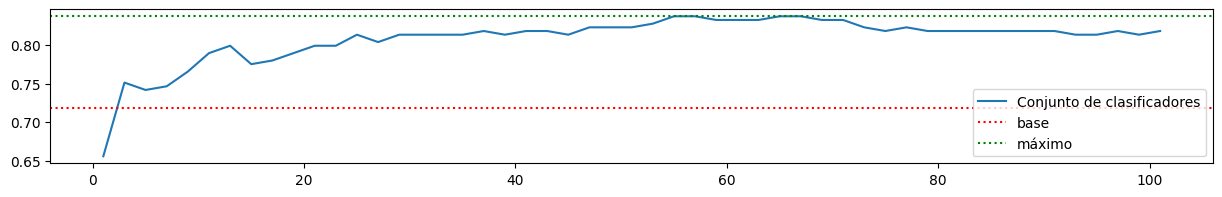

In [16]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

## Bagging en Sklearn

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(n_estimators=5)
bagging.fit(x_train, y_train)
bagging.score(x_test, y_test)

---

# Boosting

El Boosting consiste en hacer que cada clasificador del conjunto intenta mejorar los errores de los anteriores.

- Cada dato tiene un peso asociado, que determina la probabilidad de ser elegido para construir el siguiente clasificador.
- El peso aumenta para los datos mal clasificados.
- El peso disminuye para los datos bien clasificados.
- El voto de los clasificadores es ponderado en base a su error.


In [20]:
NUM_CLASIFICADORES = 101

boosting_x = []
boosting_y = []
weights = np.ones(len(x_train.values))/len(x_train.values)
clasificadores = []
for _ in range(NUM_CLASIFICADORES):
  # Importante definir p=weights
  indices = np.random.choice(len(x_train.values), size=len(x_train.values), p=weights, replace=True)
  tree = DecisionTreeClassifier()
  tree.fit(x_train.values[indices], y_train.values[indices])
  clasificadores.append(tree)

  # Actualización de pesos, por ejemplo *2 a los fallos y /2 a los aciertos
  preds = tree.predict(x_train.values)
  fallos = np.where(preds != y_train)[0]
  aciertos = np.where(preds == y_train)[0]
  weights[fallos] *= 2
  weights[aciertos] /= 2
  weights /= weights.sum()

In [22]:
preds = []
for cl in conjunto_clasificadores:
  preds.append(cl.predict(x_test.values))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

0.8181818181818182

## Curva de accuracy según el número de clasificadores

In [24]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl in conjunto_clasificadores[:i]:
    preds.append(cl.predict(x_test.values))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

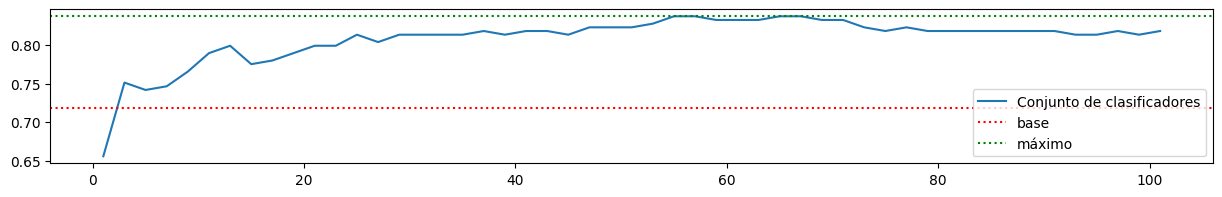

In [26]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

## Boosting en Sklearn

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

boosting = AdaBoostClassifier(n_estimators=5)
boosting.fit(x_train, y_train)
boosting.score(x_test, y_test)

---

# Random Forest

En Random Forest, cada clasificador se entrena con un subconjunto distinto de los atributos usando bagging. Normalmente son árboles sin poda.

In [46]:
NUM_CLASIFICADORES = 101
NUM_ATRIBUTOS = len(x_train.columns)
NUM_ATRIBUTOS_RANDOM_FOREST = 24

bagging_x, bagging_y = bagging(NUM_CLASIFICADORES, x_train.values, y_train.values)
clasificadores = []
atributos = []
for i in range(NUM_CLASIFICADORES):
  attr = np.random.choice(len(x_train.columns), NUM_ATRIBUTOS_RANDOM_FOREST, replace=False)
  atributos.append(attr)
  data_x = bagging_x[i][:, attr]
  data_y = bagging_y[i]
  tree = DecisionTreeClassifier()
  tree.fit(data_x, data_y)
  clasificadores.append(tree)

In [47]:
preds = []
for cl, attr in zip(clasificadores, atributos):
  preds.append(cl.predict(x_test.values[:, attr]))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

0.8038277511961722

## Curva de accuracy según el número de clasificadores

In [48]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl, attr in zip(clasificadores[:i], atributos[:i]):
    preds.append(cl.predict(x_test.values[:, attr]))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

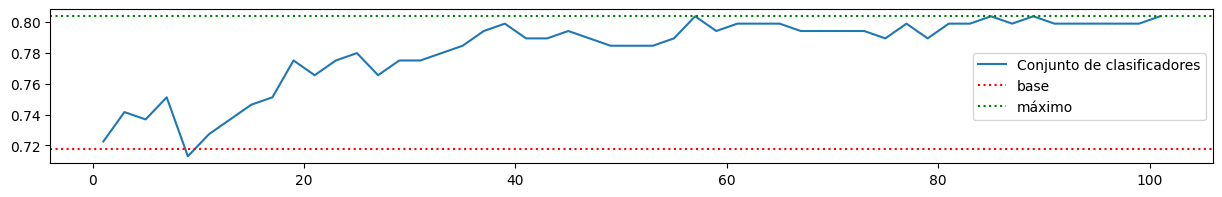

In [49]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

## Random Forest en Sklearn

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=101)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.8133971291866029

---

# Class Switching

Se alteran los datos modificando las clases aleatoriamente con probabilidad P.

In [69]:
P = 0.3
NUM_CLASIFICADORES = 101

class_switching = []
for _ in range(NUM_CLASIFICADORES):
  y_switch = np.copy(y_train)*1
  indices = np.where(np.random.rand(len(x_train.values)) <= P)[0]
  y_switch[indices] += 1
  y_switch = (y_switch % 2) == 1
  class_switching.append(y_switch)

In [70]:
clasificadores = []
for i in range(NUM_CLASIFICADORES):
  tree = DecisionTreeClassifier()
  tree.fit(x_train.values, class_switching[i])
  clasificadores.append(tree)

In [71]:
preds = []
for cl in clasificadores:
  preds.append(cl.predict(x_test.values))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

0.7990430622009569

## Curva de accuracy según el número de clasificadores

In [74]:
curva = []
for i in range(1, NUM_CLASIFICADORES+1, 2):
  preds = []
  for cl in clasificadores[:i]:
    preds.append(cl.predict(x_test.values))
  preds = np.array(preds)
  pred_conjunto = (preds.mean(axis=0) > 0.5)*1
  acc = np.mean(pred_conjunto == y_test)
  curva.append(acc)

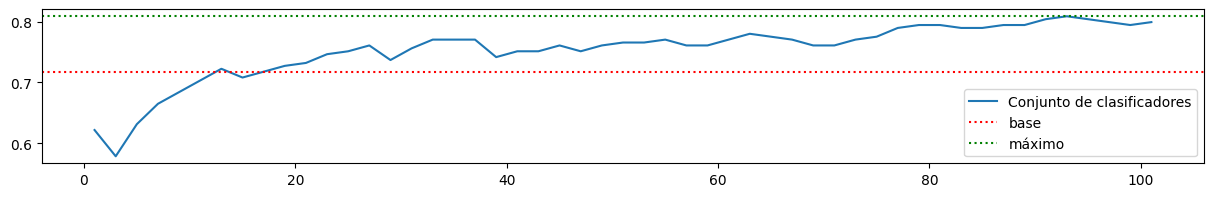

In [75]:
plt.figure(figsize=(15, 2))
plt.plot(range(1, NUM_CLASIFICADORES+1, 2), curva, label="Conjunto de clasificadores")
plt.axhline(base_tree.score(x_test, y_test), linestyle=':', color="red", label="base")
plt.axhline(max(curva), linestyle=':', color="green", label="máximo")
plt.legend()
plt.show()

---

# Combinación de clasificadores

Esta estrategia consiste en entrenar diferentes modelos con diferentes hiperparámetros y cada uno es un clasificador.

In [76]:
clasificadores = []

In [77]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
clasificadores.append(knn)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)
clasificadores.append(nb)

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
clasificadores.append(tree)

In [79]:
preds = []
for cl in clasificadores:
  preds.append(cl.predict(x_test))
preds = np.array(preds)
pred_conjunto = (preds.mean(axis=0) > 0.5)*1
acc = np.mean(pred_conjunto == y_test)
acc

0.6985645933014354